In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals.six import StringIO  
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pydotplus
from IPython.display import Image  

import graphviz


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Step 2. Import the dataset

In [3]:
import multiprocessing

def worker():
    #worker function
    print ('Worker')
    x = 0
    while x < 1000:
        print(x)
        x += 1
    return

if __name__ == '__main__':
    jobs = []
    for i in range(50):
        p = multiprocessing.Process(target=worker)
        jobs.append(p)
        p.start()

In [4]:
from multiprocessing import Process, Lock

def f(l, i):
    l.acquire()
    print('worker ', i)
    x = 0
    while x < 1000:
        print(x)
        x += 1
    l.release()

if __name__ == '__main__': 
    lock = Lock()
    for num in range(50):
        Process(target=f, args=(lock, num)).start()

In [5]:
# Import the data
df = pd.read_csv('US_Accidents_Dec19.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               object
End_Time                 object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [6]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2974335 entries, 0 to 2974334
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

### Step 4. Deal with outliers

#### A. Drop rows with negative time_duration

In [7]:
# Check if there is any negative time_duration values
df1=df[df[td]>=0]
df1.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,Time_Duration(min)
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2016,Feb,8,5,Mon,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day,2016,Feb,8,6,Mon,30.0
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day,2016,Feb,8,6,Mon,30.0
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day,2016,Feb,8,7,Mon,30.0
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2016,Feb,8,7,Mon,30.0


In [8]:
df1[td].describe()

count    2.974318e+06
mean     1.211138e+02
std      3.678439e+03
min     -0.000000e+00
25%      3.000000e+01
50%      4.500000e+01
75%      7.500000e+01
max      1.786320e+06
Name: Time_Duration(min), dtype: float64

In [9]:
df1[td]=df1[td].replace(-0.0,0)

### Step 4. Deal with outliers

#### B. Fill outliers with median values

In [10]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df1[td].max(),round(df1[td].max()/60), round(df1[td].max()/60/24), df1[td].min()))

Max time to clear an accident: 1786320.0 minutes or 29772.0 hours or 1240.0 days; Min to clear an accident td: 0.0 minutes.


In [11]:
df1.isnull().sum()/len(df1)*100

ID                        0.000000
Source                    0.000000
TMC                      24.478452
Severity                  0.000000
Start_Time                0.000000
End_Time                  0.000000
Start_Lat                 0.000000
Start_Lng                 0.000000
End_Lat                  75.521548
End_Lng                  75.521548
Distance(mi)              0.000000
Description               0.000034
Number                   64.471788
Street                    0.000000
Side                      0.000000
City                      0.002791
County                    0.000000
State                     0.000000
Zipcode                   0.029587
Country                   0.000000
Timezone                  0.106344
Airport_Code              0.191338
Weather_Timestamp         1.234064
Temperature(F)            1.884903
Wind_Chill(F)            62.287018
Humidity(%)               1.989464
Pressure(in)              1.618590
Visibility(mi)            2.208607
Wind_Direction      

In [12]:
df1.shape

(2974318, 55)

In [13]:
df.shape

(2974335, 55)

### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [14]:
feature_lst=['Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Precipitation(in)','Wind_Speed(mph)','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)','Month']

In [15]:
df2=df1[feature_lst]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2974318 entries, 0 to 2974334
Data columns (total 35 columns):
Severity              int64
Start_Lng             float64
Start_Lat             float64
Distance(mi)          float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)        float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction        object
Weather_Condition     object
Amenity               bool
Bump                  bool
Crossing              bool
Give_Way              bool
Junction              bool
No_Exit               bool
Railway               bool
Roundabout            bool
Station               bool
Stop                  bool
Traffic_Calming       bool
Precipitation(in)     float64
Wind_Speed(mph)       float64
Traffic_Signal        bool
Turning_Loop          bool
Sunrise_Sunset        object
Hour  

In [16]:
df2.isnull().sum()/len(df2)*100

Severity               0.000000
Start_Lng              0.000000
Start_Lat              0.000000
Distance(mi)           0.000000
Side                   0.000000
City                   0.002791
County                 0.000000
State                  0.000000
Timezone               0.106344
Temperature(F)         1.884903
Humidity(%)            1.989464
Pressure(in)           1.618590
Visibility(mi)         2.208607
Wind_Direction         1.516348
Weather_Condition      2.216710
Amenity                0.000000
Bump                   0.000000
Crossing               0.000000
Give_Way               0.000000
Junction               0.000000
No_Exit                0.000000
Railway                0.000000
Roundabout             0.000000
Station                0.000000
Stop                   0.000000
Traffic_Calming        0.000000
Precipitation(in)     67.186864
Wind_Speed(mph)       14.821347
Traffic_Signal         0.000000
Turning_Loop           0.000000
Sunrise_Sunset         0.003127
Hour    

### Step 6.  missing values imputation

In [17]:
df2=df2[df2['Severity']!=1]

In [18]:
df2 = df2.dropna(axis=0, subset=['City'])

In [19]:
df2.isnull().sum()

Severity                    0
Start_Lng                   0
Start_Lat                   0
Distance(mi)                0
Side                        0
City                        0
County                      0
State                       0
Timezone                 3163
Temperature(F)          56043
Humidity(%)             59151
Pressure(in)            48126
Visibility(mi)          65666
Wind_Direction          45087
Weather_Condition       65905
Amenity                     0
Bump                        0
Crossing                    0
Give_Way                    0
Junction                    0
No_Exit                     0
Railway                     0
Roundabout                  0
Station                     0
Stop                        0
Traffic_Calming             0
Precipitation(in)     1997565
Wind_Speed(mph)        440665
Traffic_Signal              0
Turning_Loop                0
Sunrise_Sunset             10
Hour                        0
Weekday                     0
Time_Durat

In [20]:
df19=df2.copy()

In [21]:
df19["Weather_Condition"] = df19["Weather_Condition"].groupby(by=[df19.State,df19.Month]).apply(lambda x: x.replace(np.nan,x.mode()[0]))

In [22]:
df19["Wind_Direction"] = df19["Wind_Direction"].groupby(by=[df19.State,df19.Month]).apply(lambda x: x.replace(np.nan,x.mode()[0]))

In [23]:
df19['Precipitation(in)']=df19['Precipitation(in)'].groupby(by=[df19.Weather_Condition]).apply(lambda x: x.fillna(x.mean()))

df19['Precipitation(in)']=df19['Precipitation(in)'].groupby(by=[df19.City,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))

df19['Precipitation(in)']=df19['Precipitation(in)'].groupby(by=[df19.County,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))


In [24]:

df19['Wind_Speed(mph)']=df19['Wind_Speed(mph)'].groupby(by=[df19.City,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))


df19['Wind_Speed(mph)']=df19['Wind_Speed(mph)'].groupby(by=[df19.County,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))


In [25]:

df19['Visibility(mi)']=df19['Visibility(mi)'].groupby(by=[df19.City,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))

df19['Visibility(mi)']=df19['Visibility(mi)'].groupby(by=[df19.County,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))


In [26]:

df19['Humidity(%)']=df19['Humidity(%)'].groupby(by=[df19.City,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))

df19['Humidity(%)']=df19['Humidity(%)'].groupby(by=[df19.County,df19.Month,df19.Sunrise_Sunset]).apply(lambda x: x.fillna(x.mean()))


In [27]:
df19['Temperature(F)']=df19['Temperature(F)'].groupby(by=[df19.Weather_Condition]).apply(lambda x: x.fillna(x.mean()))

In [28]:
df19['Pressure(in)']=df19['Pressure(in)'].groupby(by=[df19['Temperature(F)']]).apply(lambda x: x.fillna(x.mean()))

In [29]:
df19.Severity.value_counts()

2    1993337
3     887607
4      92323
Name: Severity, dtype: int64

In [30]:
df19=df19.drop(columns=['Timezone'])

In [31]:
df19.isnull().sum()

Severity                 0
Start_Lng                0
Start_Lat                0
Distance(mi)             0
Side                     0
City                     0
County                   0
State                    0
Temperature(F)          19
Humidity(%)            264
Pressure(in)            27
Visibility(mi)         290
Wind_Direction           0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Precipitation(in)       10
Wind_Speed(mph)       1046
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset          10
Hour                     0
Weekday                  0
Time_Duration(min)       0
Month                    0
dtype: int64

In [32]:
df19.shape

(2973267, 34)

In [33]:
df19=df19[df19['Temperature(F)']<110]
df19=df19[df19['Temperature(F)']>-20]
df19=df19[df19['Pressure(in)']>20]
df19=df19[df19['Visibility(mi)']<60]
df19=df19[df19['Wind_Speed(mph)']<100]
df19=df19[df19['Precipitation(in)']<10]
df19=df19[df19['Distance(mi)']<50]

In [34]:
df19.shape

(2970230, 34)

In [35]:
# removing the extreme values from each features which are very extreme

In [36]:
df3=df19.dropna()

In [37]:
df3.isnull().sum()

Severity              0
Start_Lng             0
Start_Lat             0
Distance(mi)          0
Side                  0
City                  0
County                0
State                 0
Temperature(F)        0
Humidity(%)           0
Pressure(in)          0
Visibility(mi)        0
Wind_Direction        0
Weather_Condition     0
Amenity               0
Bump                  0
Crossing              0
Give_Way              0
Junction              0
No_Exit               0
Railway               0
Roundabout            0
Station               0
Stop                  0
Traffic_Calming       0
Precipitation(in)     0
Wind_Speed(mph)       0
Traffic_Signal        0
Turning_Loop          0
Sunrise_Sunset        0
Hour                  0
Weekday               0
Time_Duration(min)    0
Month                 0
dtype: int64

### Step 7. Select the state of interest: PA; and County of interest: Montgomery
   

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [38]:
df4=df3['County'][df3['State']=='PA'].value_counts()
df4.head()

Montgomery      30563
Lancaster       10150
York             8571
Allegheny        7831
Philadelphia     6353
Name: County, dtype: int64

In [39]:
# Set state
state='PA'

df_state=df3.loc[df3.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90279 entries, 197865 to 2973937
Data columns (total 33 columns):
Severity              90279 non-null int64
Start_Lng             90279 non-null float64
Start_Lat             90279 non-null float64
Distance(mi)          90279 non-null float64
Side                  90279 non-null object
City                  90279 non-null object
County                90279 non-null object
Temperature(F)        90279 non-null float64
Humidity(%)           90279 non-null float64
Pressure(in)          90279 non-null float64
Visibility(mi)        90279 non-null float64
Wind_Direction        90279 non-null object
Weather_Condition     90279 non-null object
Amenity               90279 non-null bool
Bump                  90279 non-null bool
Crossing              90279 non-null bool
Give_Way              90279 non-null bool
Junction              90279 non-null bool
No_Exit               90279 non-null bool
Railway               90279 non-null bool
Roundabout  

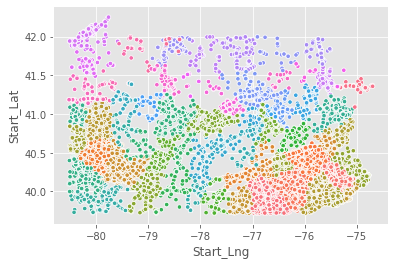

In [40]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

In [41]:
# Set county
county='Montgomery'

# Select the state of Pennsylvania
df_county=df_state.loc[df_state.County==county].copy()
df_county.drop('County',axis=1, inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30563 entries, 228553 to 2973450
Data columns (total 32 columns):
Severity              30563 non-null int64
Start_Lng             30563 non-null float64
Start_Lat             30563 non-null float64
Distance(mi)          30563 non-null float64
Side                  30563 non-null object
City                  30563 non-null object
Temperature(F)        30563 non-null float64
Humidity(%)           30563 non-null float64
Pressure(in)          30563 non-null float64
Visibility(mi)        30563 non-null float64
Wind_Direction        30563 non-null object
Weather_Condition     30563 non-null object
Amenity               30563 non-null bool
Bump                  30563 non-null bool
Crossing              30563 non-null bool
Give_Way              30563 non-null bool
Junction              30563 non-null bool
No_Exit               30563 non-null bool
Railway               30563 non-null bool
Roundabout            30563 non-null bool
Station       

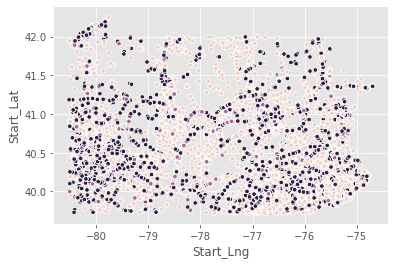

In [42]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='Severity', legend=False, s=20)
plt.show()

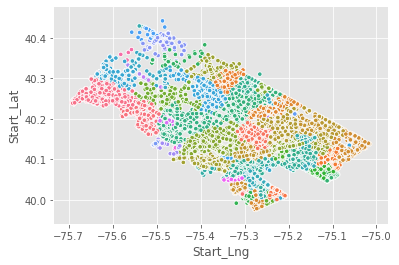

In [43]:
# Map of accidents, color code by city

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
plt.show()

In [44]:
pd.DataFrame(df_county).to_csv("df_county.csv",index=False)

# Treating categorical features

In [45]:
df=pd.read_csv('df_county.csv')

In [46]:
cat_cols=df.select_dtypes(['object'])


In [47]:
X=pd.concat([cat_cols,df['Severity']],axis=1)


In [48]:
X=X.drop(columns=['Side','Sunrise_Sunset'])

In [49]:
y=X['Severity']
cols=X.drop(['Severity'],axis=1).columns

In [50]:
for i in X.columns:
    print(i,X[i].value_counts().count())

City 75
Wind_Direction 24
Weather_Condition 30
Weekday 7
Month 12
Severity 3


In [51]:
for i in X.columns:
    if X[i].dtypes=='float64':
        X[i]=X[i].astype('float32')
    elif X[i].dtypes=='int64':
        X[i]=X[i].astype('int32')

In [52]:
X.dtypes

City                 object
Wind_Direction       object
Weather_Condition    object
Weekday              object
Month                object
Severity              int32
dtype: object

In [53]:
from sklearn.model_selection import KFold

X_fold=X.copy()

kf = KFold(n_splits = 10, shuffle = False)
for train_ind,val_ind in kf.split(X):
    for col in cols:
        if(X_fold[col].dtype=='object'):
            replaced=dict(X.iloc[train_ind][[col,'Severity']].groupby(col)['Severity'].mean())
            X_fold.loc[val_ind,col]=X_fold.iloc[val_ind][col].replace(replaced).values


In [54]:
for i in X_fold.columns:
    X_fold[i]=pd.to_numeric(X_fold[i], errors='coerce')


In [55]:
boolcols=df.select_dtypes(['bool'])

In [56]:
lecols=pd.concat([boolcols,df['Side'],df['Sunrise_Sunset'],df['Severity']],axis=1)

In [57]:
X_fold=X_fold.drop(columns=['Severity'])

In [58]:
df=df.drop(columns=['Severity'])

In [59]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_encoded = lecols.apply(le.fit_transform)
df_encoded.dtypes

Amenity            int64
Bump               int64
Crossing           int64
Give_Way           int64
Junction           int64
No_Exit            int64
Railway            int64
Roundabout         int64
Station            int64
Stop               int64
Traffic_Calming    int64
Traffic_Signal     int64
Turning_Loop       int64
Side               int32
Sunrise_Sunset     int32
Severity           int64
dtype: object

In [60]:
df=df.drop(columns=df.select_dtypes(['object']),axis=1)
df=df.drop(columns=df.select_dtypes(['bool']),axis=1)

In [61]:
df_final=pd.concat([df,X_fold,df_encoded],axis=1)


In [63]:
df_final=df_final.dropna()

In [64]:
for i in df_final.columns:
    if df_final[i].dtypes=='float64':
        df_final[i]=df_final[i].astype('float32')
    elif df_final[i].dtypes=='int64':
        df_final[i]=df_final[i].astype('int32')

In [65]:
pd.DataFrame(df_final).to_csv("df_final.csv",index=False)

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [66]:
df=pd.read_csv('df_final.csv')

In [67]:
df.shape

(30551, 32)

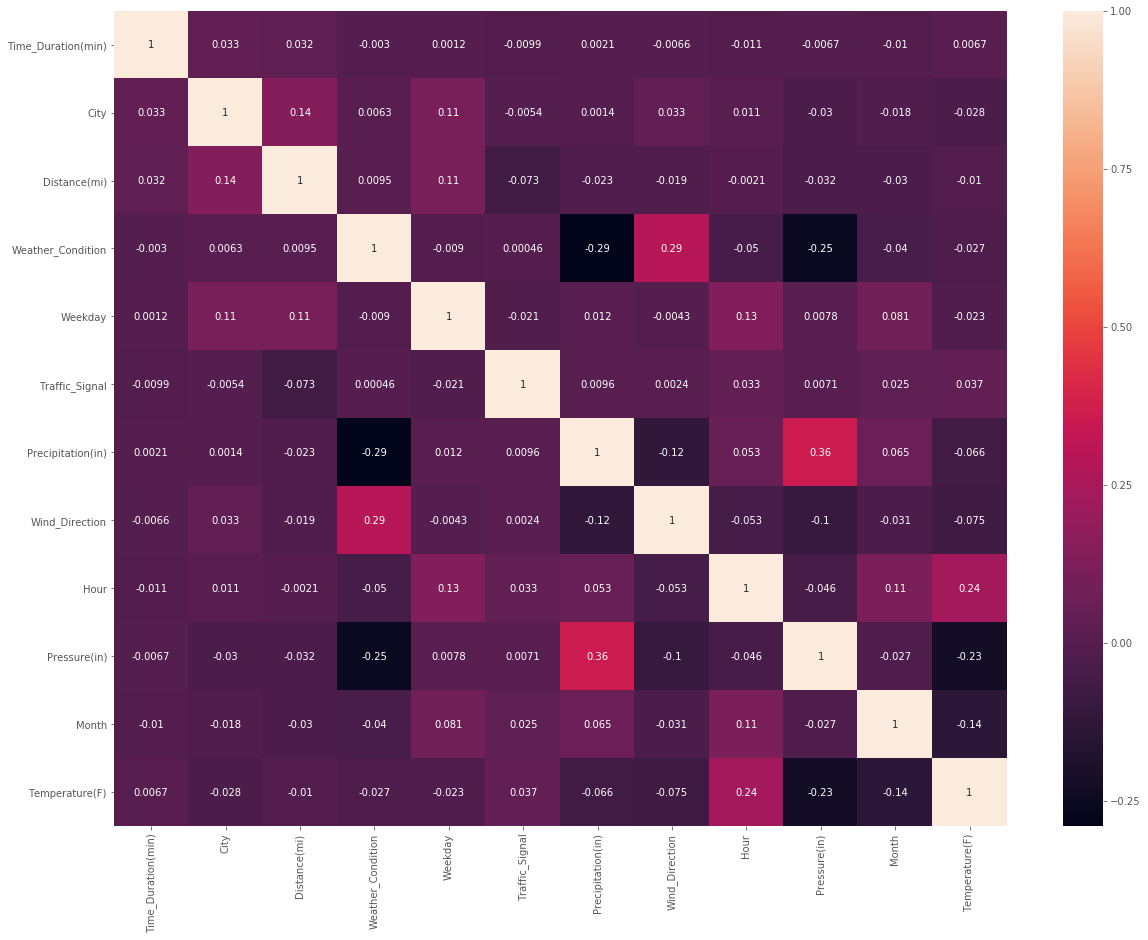

In [68]:
plt.figure(figsize = (20,15))
sns.heatmap(df[['Time_Duration(min)', 'City', 'Distance(mi)', 'Weather_Condition', 'Weekday', 'Traffic_Signal', 'Precipitation(in)',
       'Wind_Direction', 'Hour', 'Pressure(in)', 'Month', 'Temperature(F)']].corr(),annot=True)

In [69]:

target='Severity'



y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [70]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

acc=accuracy_score(y_test, y_pred)


print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.926.


In [71]:
lr.score(X_train,y_train)

0.9255728314238952

In [72]:
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5593
           1       0.75      0.17      0.28       472
           2       0.00      0.00      0.00        46

    accuracy                           0.93      6111
   macro avg       0.56      0.39      0.41      6111
weighted avg       0.91      0.93      0.90      6111



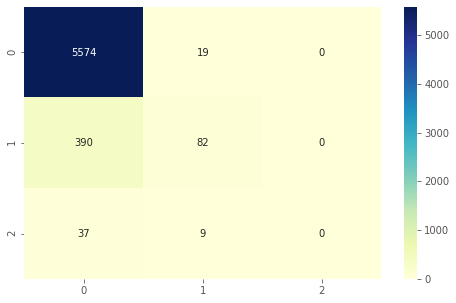

In [73]:
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [74]:
cols = ['Train score','Test score','Difference']

# creating an empty dataframe of the colums
result_tabulation = pd.DataFrame(columns = cols)

# compiling the required information
Logistic_regression_metrics = pd.Series({'Model': "Logistic regression ",
                     'Train score' : lr.score(X_train,y_train),
                 'Test score': lr.score(X_test,y_test),
                 'Difference': (lr.score(X_train,y_train)-lr.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(Logistic_regression_metrics , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression


In [75]:
#since the recall score is low we are rebuilding the model after smote

In [76]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
X, y = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [77]:
# Base model regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)


print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.746.


In [78]:
lr.score(X_train,y_train)

0.750204884445173

In [79]:
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      5592
           1       0.65      0.62      0.64      5593
           2       0.91      0.71      0.80      5593

    accuracy                           0.75     16778
   macro avg       0.76      0.75      0.75     16778
weighted avg       0.76      0.75      0.75     16778



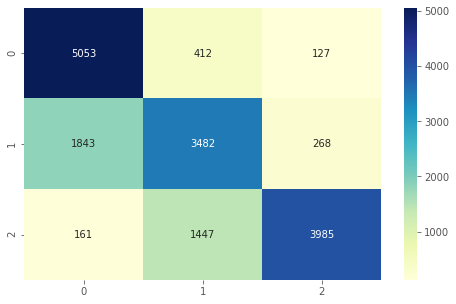

In [80]:
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [81]:
# we can see that there is a significant increase in recall score after smote

In [82]:

# compiling the required information
Logistic_regression_metrics_sm = pd.Series({'Model': "Logistic regression with sm",
                     'Train score' : lr.score(X_train,y_train),
                 'Test score': lr.score(X_test,y_test),
                 'Difference': (lr.score(X_train,y_train)-lr.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(Logistic_regression_metrics_sm , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm



   ##### KNN with 6 neighors

In [83]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)
y_predt = knn.predict(X_train)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)


print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))


[K-Nearest Neighbors (KNN)] knn.score: 0.916.


In [84]:
knn.score(X_train,y_train)

0.9438393109922367

In [85]:
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      5592
           1       0.84      0.96      0.89      5593
           2       0.97      1.00      0.99      5593

    accuracy                           0.92     16778
   macro avg       0.92      0.92      0.91     16778
weighted avg       0.92      0.92      0.91     16778



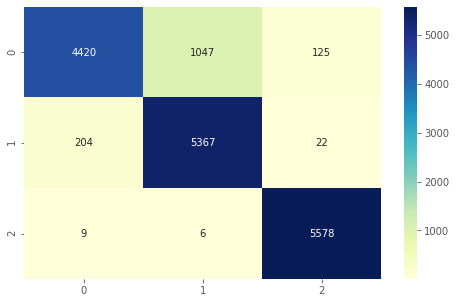

In [86]:
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [87]:


# compiling the required information
Knnmodel = pd.Series({'Model': "Knnmodel",
                     'Train score' : knn.score(X_train,y_train),
                 'Test score': knn.score(X_test,y_test),
                 'Difference': (knn.score(X_train,y_train)-knn.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(Knnmodel , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

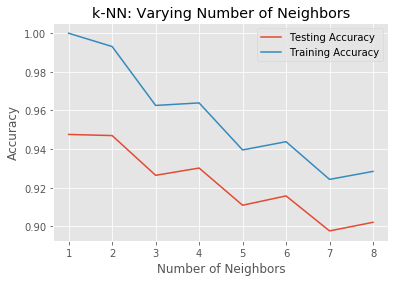

In [88]:
 # Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
     # Setup a k-NN Classifier with n_neighbor
     knn = KNeighborsClassifier(n_neighbors=n_neighbor)

     # Fit the classifier to the training data
     knn.fit(X_train,y_train)
    
     #Compute accuracy on the training set
     train_accuracy[i] = knn.score(X_train, y_train)

     #Compute accuracy on the testing set
     test_accuracy[i] = knn.score(X_test, y_test)

# # Generate plot
 plt.title('k-NN: Varying Number of Neighbors')
 plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
 plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
 plt.legend()
 plt.xlabel('Number of Neighbors')
 plt.ylabel('Accuracy')
 plt.show()


In [89]:
# we can see that there is a drop in both test and train 

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=100                 

In [90]:
clf=RandomForestClassifier(n_estimators=50)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


acc=accuracy_score(y_test, y_pred)


print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Randon forest algorithm] accuracy_score: 0.981.


In [91]:
clf.score(X_train,y_train)

0.999955297939235

In [92]:
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5592
           1       0.97      0.98      0.97      5593
           2       0.99      1.00      1.00      5593

    accuracy                           0.98     16778
   macro avg       0.98      0.98      0.98     16778
weighted avg       0.98      0.98      0.98     16778



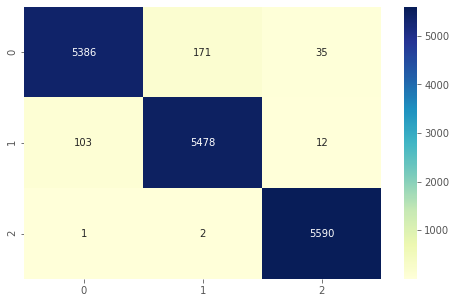

In [93]:
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [94]:

# compiling the required information
RANDOMFOREST = pd.Series({'Model': "RANDOMFOREST",
                     'Train score' : clf.score(X_train,y_train),
                 'Test score': clf.score(X_test,y_test),
                 'Difference': (clf.score(X_train,y_train)-clf.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(RANDOMFOREST , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel
3,0.999955,0.980689,0.019266,RANDOMFOREST


In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 80],
    'min_samples_leaf': [2,3],
    'min_samples_split': [8, 10],
    'n_estimators': [50, 100]
}

In [97]:
rf = RandomForestClassifier()

In [98]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)

In [99]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   7.0s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   7.1s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=50, total=   7.2s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=  14.3s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=  14.1s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=8, n_estimators=100, total=  14.9s
[CV] bootstrap=True, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_est

[CV]  bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   6.7s
[CV] bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   6.7s
[CV] bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=50, total=   6.3s
[CV] bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  14.3s
[CV] bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  18.2s
[CV] bootstrap=True, max_depth=80, min_samples_leaf=3, min_samples_split=10

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  8.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [100]:
best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [101]:
best_grid

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [102]:
rf=best_grid

In [103]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
yp=rf.predict(X_test)

In [105]:
rf.score(X_train,y_train)

0.9945314478997482

In [106]:
print(classification_report (y_test, yp))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5592
           1       0.97      0.98      0.97      5593
           2       0.99      1.00      0.99      5593

    accuracy                           0.98     16778
   macro avg       0.98      0.98      0.98     16778
weighted avg       0.98      0.98      0.98     16778



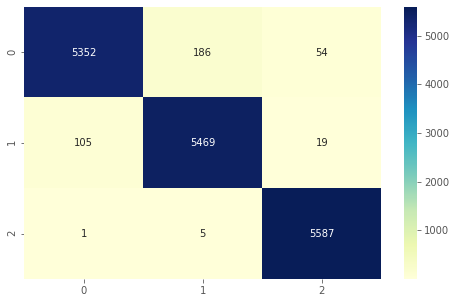

In [107]:
# compute the confusion matrix
cm = confusion_matrix(y_test, yp)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [108]:


# compiling the required information
RANDOMFORESTcv = pd.Series({'Model': "RANDOMFOREST with cv",
                     'Train score' : rf.score(X_train,y_train),
                 'Test score': rf.score(X_test,y_test),
                 'Difference': (rf.score(X_train,y_train)-rf.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(RANDOMFORESTcv , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel
3,0.999955,0.980689,0.019266,RANDOMFOREST
4,0.994531,0.977947,0.016584,RANDOMFOREST with cv


In [109]:
feature_names = list(X_train.columns)
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)


In [110]:
feature_imp

Distance(mi)          0.176365
City                  0.164237
Time_Duration(min)    0.149737
Weekday               0.111403
Start_Lat             0.054373
Wind_Direction        0.043928
Weather_Condition     0.043069
Start_Lng             0.040858
Traffic_Signal        0.039119
Month                 0.037041
Precipitation(in)     0.020370
Hour                  0.017798
Temperature(F)        0.017791
Pressure(in)          0.016311
Humidity(%)           0.015424
Side                  0.014934
Wind_Speed(mph)       0.012818
Crossing              0.010419
Visibility(mi)        0.007972
Sunrise_Sunset        0.001711
Stop                  0.001253
Junction              0.001171
Give_Way              0.000940
Amenity               0.000831
Railway               0.000068
Station               0.000059
Roundabout            0.000000
No_Exit               0.000000
Bump                  0.000000
Traffic_Calming       0.000000
Turning_Loop          0.000000
dtype: float64

In [111]:
feature_imp[feature_imp>0.02].index

Index(['Distance(mi)', 'City', 'Time_Duration(min)', 'Weekday', 'Start_Lat',
       'Wind_Direction', 'Weather_Condition', 'Start_Lng', 'Traffic_Signal',
       'Month', 'Precipitation(in)'],
      dtype='object')

In [112]:
# Assign the data
# df=df_county_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df[['Time_Duration(min)', 'Distance(mi)', 'City', 'Start_Lat', 'Start_Lng',
       'Weather_Condition', 'Traffic_Signal', 'Weekday', 'Precipitation(in)',
       'Hour', 'Wind_Direction', 'Pressure(in)', 'Month']]


sm = SMOTE(random_state=27)
X, y = sm.fit_sample(X, y)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [113]:
dd = RandomForestClassifier()

In [114]:
dd.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
yp=dd.predict(X_test)

In [116]:
dd.score(X_train,y_train)

0.9999701986261567

In [117]:
accuracy_score(y_test,yp)

0.9785433305519132

In [118]:
print(classification_report (y_test,yp))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5592
           1       0.97      0.98      0.97      5593
           2       0.99      1.00      0.99      5593

    accuracy                           0.98     16778
   macro avg       0.98      0.98      0.98     16778
weighted avg       0.98      0.98      0.98     16778



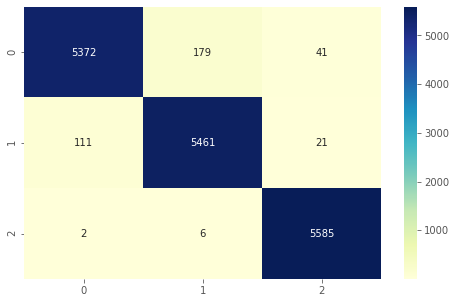

In [119]:
# compute the confusion matrix
cm = confusion_matrix(y_test, yp)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [120]:


# compiling the required information
RANDOMFORESTfs = pd.Series({'Model': "RANDOMFOREST with Feature selection",
                     'Train score' : dd.score(X_train,y_train),
                 'Test score': dd.score(X_test,y_test),
                 'Difference': (dd.score(X_train,y_train)-dd.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(RANDOMFORESTfs , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel
3,0.999955,0.980689,0.019266,RANDOMFOREST
4,0.994531,0.977947,0.016584,RANDOMFOREST with cv
5,0.999970,0.978543,0.021427,RANDOMFOREST with Feature selection


# decision_tree_classification

In [121]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=27)
X, y = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [122]:
decision_tree_classification = DecisionTreeClassifier()


In [123]:
decision_tree = decision_tree_classification.fit(X_train, y_train)

In [124]:
decision_tree_pred = decision_tree.predict(X_test)

In [125]:
# accuracy measures by classification_report()
result = classification_report(y_test, decision_tree_pred)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5592
           1       0.95      0.95      0.95      5593
           2       0.98      0.99      0.99      5593

    accuracy                           0.96     16778
   macro avg       0.96      0.96      0.96     16778
weighted avg       0.96      0.96      0.96     16778



In [126]:
accuracy_score=decision_tree.score(X_test,y_test)
accuracy_score

0.9637024675169865

In [127]:
decision_tree.score(X_train,y_train)

0.9999850993130783

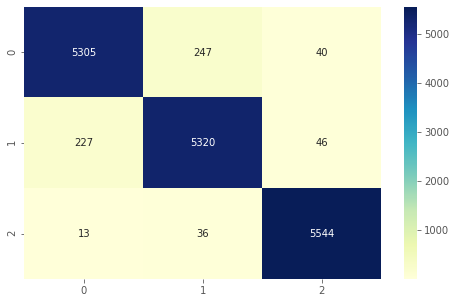

In [128]:
# compute the confusion matrix
cm = confusion_matrix(y_test, decision_tree_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [129]:


# compiling the required information
Decisiontree = pd.Series({'Model': "Decisiontree",
                     'Train score' : decision_tree.score(X_train,y_train),
                 'Test score': decision_tree.score(X_test,y_test),
                 'Difference': (decision_tree.score(X_train,y_train)-decision_tree.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(Decisiontree , ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel
3,0.999955,0.980689,0.019266,RANDOMFOREST
4,0.994531,0.977947,0.016584,RANDOMFOREST with cv
5,0.999970,0.978543,0.021427,RANDOMFOREST with Feature selection
6,0.999985,0.963702,0.036283,Decisiontree


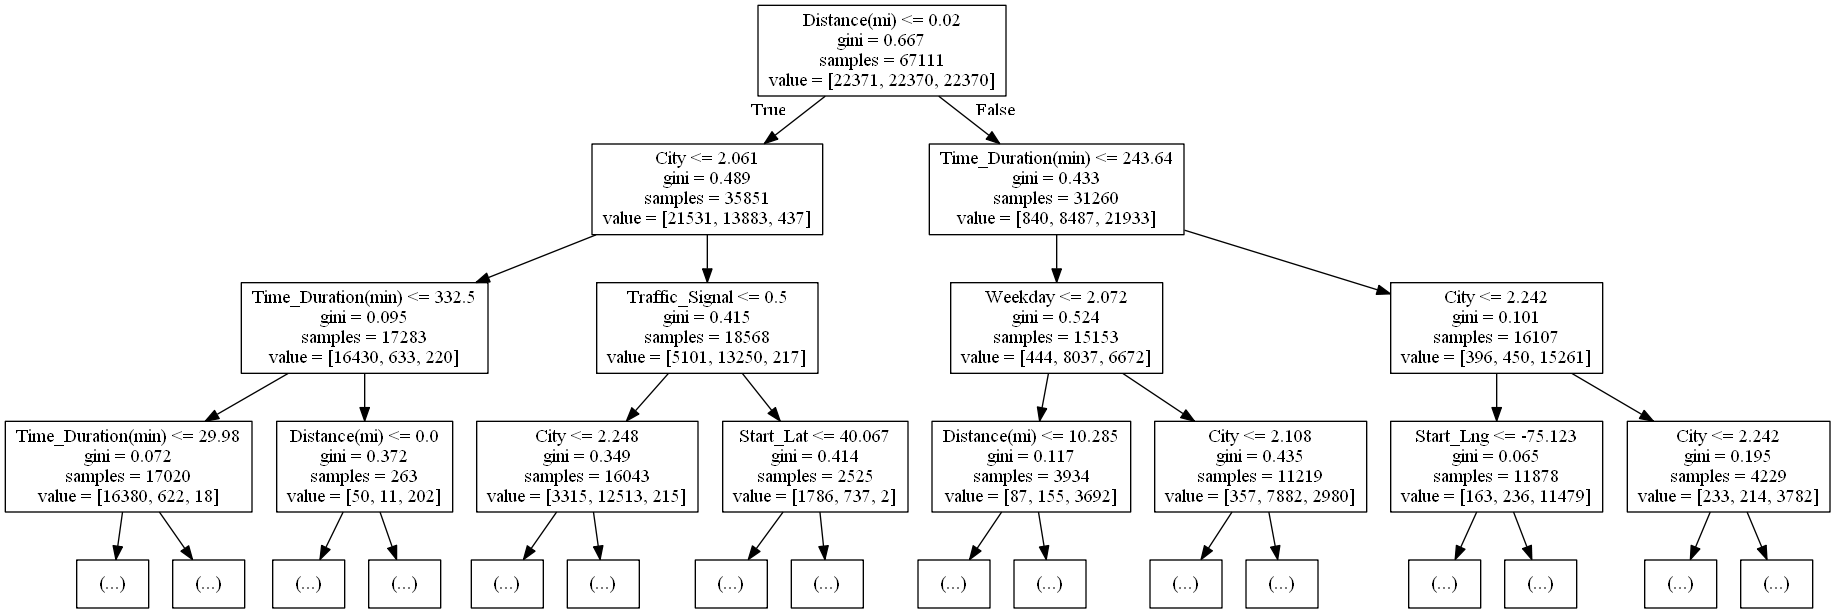

In [130]:
# plot the decision tree
lables = X_train.columns

dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                         feature_names= lables,max_depth=3)  

# plot the decision tree
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# Note: The image might get scaled and might not be clearly visible
# Please double-click on the image below to get an expanded view

In [131]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10, 20],
              "max_depth": [3, 5, 10, 20],
              "min_samples_leaf": [30, 100, 300],
              "max_leaf_nodes": [None,2,3,5],
              }

In [132]:
decision_tree_Gridsearch = DecisionTreeClassifier()
decision_tree_Gridsearch = GridSearchCV(decision_tree_Gridsearch, param_grid, cv=10)
decision_tree_Gridsearch.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                  

In [133]:
decision_tree_Gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_leaf_nodes': None,
 'min_samples_leaf': 30,
 'min_samples_split': 10}

In [134]:
decision_tree_best_parameters = DecisionTreeClassifier(max_depth= decision_tree_Gridsearch.best_params_.get('max_depth'), 
                                                       min_samples_leaf= decision_tree_Gridsearch.best_params_.get('min_samples_leaf'), 
                                                       min_samples_split= decision_tree_Gridsearch.best_params_.get('min_samples_split'),
                                                       criterion=decision_tree_Gridsearch.best_params_.get('criterion')).fit(X_train, y_train)

In [135]:
decision_tree_best_parameters = decision_tree_best_parameters.fit(X_train, y_train)

In [136]:
decision_tree_pred = decision_tree_best_parameters.predict(X_test)

In [137]:
decision_tree_best_parameters.score(X_train,y_train)


0.9520942915468403

In [138]:
# accuracy measures by classification_report()
result = classification_report(y_test, decision_tree_pred)

# print the result
print(result)

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5592
           1       0.93      0.91      0.92      5593
           2       0.96      0.98      0.97      5593

    accuracy                           0.94     16778
   macro avg       0.94      0.94      0.94     16778
weighted avg       0.94      0.94      0.94     16778



In [139]:
accuracy_score=decision_tree_best_parameters.score(X_test,y_test)
accuracy_score

0.9414113720348075

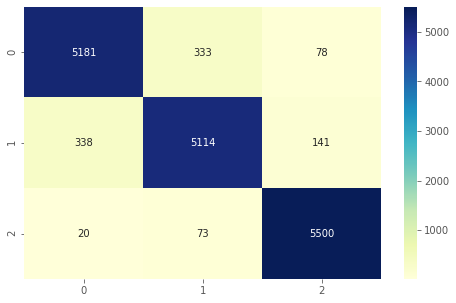

In [140]:
# compute the confusion matrix
cm = confusion_matrix(y_test, decision_tree_pred)

#
plt.figure(figsize = (8,5))

# plot a heatmap
sns.heatmap(cm, annot=True,fmt='d',cmap="YlGnBu")
plt.show()

In [141]:


# compiling the required information
Decisiontreewithbest = pd.Series({'Model': "Decisiontreecv",
                     'Train score' : decision_tree_best_parameters.score(X_train,y_train),
                 'Test score': decision_tree_best_parameters.score(X_test,y_test),
                 'Difference': (decision_tree_best_parameters.score(X_train,y_train)-decision_tree_best_parameters.score(X_test,y_test)),
                })



# appending our result table
result_tabulation = result_tabulation.append(Decisiontreewithbest, ignore_index = True)

# view the result table
result_tabulation

,Train score,Test score,Difference,Model
0,0.925573,0.925544,0.000029,Logistic regression
1,0.750205,0.746215,0.003990,Logistic regression with sm
2,0.943839,0.915783,0.028057,Knnmodel
3,0.999955,0.980689,0.019266,RANDOMFOREST
4,0.994531,0.977947,0.016584,RANDOMFOREST with cv
5,0.999970,0.978543,0.021427,RANDOMFOREST with Feature selection
6,0.999985,0.963702,0.036283,Decisiontree
7,0.952094,0.941411,0.010683,Decisiontreecv


In [142]:
pd.DataFrame(result_tabulation).to_csv("result_tabulation.csv",index=False)